# Gene Regulatory Network Analysis with SCENIC

**SCENIC** (Single-Cell rEgulatory Network Inference and Clustering) is a powerful computational method for reconstructing **gene regulatory networks (GRNs)** from single-cell RNA-seq data. This tutorial will guide you through the complete SCENIC workflow using the enhanced implementation in **OmicVerse**.

**Key Innovations in OmicVerse**

We've made **three major improvements** to the original SCENIC implementation:

1. **🚀 Speed Optimization**: Analysis time reduced from 30 minutes-12 hours to just **5-10 minutes**
2. **🔧 Dependency Management**: Resolved installation conflicts between `pySCENIC` and `RegDiffusion`
3. **🐛 Bug Fixes**: Fixed common issues that could occur during the analysis


**Citation**

If you use this tutorial, please cite:
- **SCENIC**: Van de Sande, B., et al. A scalable SCENIC workflow for single-cell gene regulatory network analysis. *Nat Protoc* 15, 2247–2276 (2020).
- **RegDiffusion**: Zhu H, Slonim D. From Noise to Knowledge: Diffusion Probabilistic Model-Based Neural Inference of Gene Regulatory Networks. *J Comput Biol* 31(11):1087-1103 (2024).

Let's begin!

In [1]:
# Import required packages and set up the environment
import scanpy as sc
import omicverse as ov
import numpy as np
import pandas as pd

# Set up plotting parameters
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Arial font downloaded successfully to: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] Tesla V100-SXM2-16GB
    • Total memory: 15.8 GB
    • Compute capability: 7.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.2rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## 1. Data Preparation

### Loading the Dataset

For this tutorial, we'll use the **mouse hematopoiesis dataset** from [Nestorowa et al. (2016, Blood)](https://doi.org/10.1182/blood-2016-05-716480). This dataset contains single-cell RNA-seq data from mouse hematopoietic stem and progenitor cells, making it ideal for studying regulatory networks in cell differentiation.

### Dataset Information

The dataset includes:
- **1,645 cells** from mouse bone marrow
- **3,000 highly variable genes**
- **Multiple cell types**: HSCs, MPPs, LMPPs, GMPs, CMPs, and more
- **Pseudotime information** for trajectory analysis
- **Pre-computed cell type annotations**


> **Note 1**: For your own data, you'll need to perform these preprocessing steps before running SCENIC. The raw counts should be preserved in the `layers['raw_count']` for optimal RegDiffusion performance.


> **Note 2**: In the tutorial on the official website of SCENIC, the number of genes used is 3000 HVG + TF genes

In [2]:
# Load the mouse hematopoiesis dataset
adata = ov.single.mouse_hsc_nestorowa16()

# Display basic information about the dataset
print("Dataset shape:", adata.shape)
print("Cell types available:", adata.obs['cell_type_roughly'].unique())



Load mouse_hsc_nestorowa16_v0.h5ad
Dataset shape: (1645, 3000)
Cell types available: ['MPP', 'HSC', 'LMPP', 'GMP', 'CMP', 'MEP']
Categories (6, object): ['CMP', 'GMP', 'HSC', 'LMPP', 'MEP', 'MPP']


### Required Database Files

SCENIC requires **species-specific reference databases** for motif enrichment analysis. These files are essential for the regulon inference step.

#### Database Requirements

For **mouse analysis**, you need to download the following files from the [SCENIC resources](https://resources.aertslab.org/cistarget/):

1. **Ranking Databases** (`.feather` files):
   - `mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather`
   - `mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather`

2. **Motif Annotation File** (`.tbl` file):
   - `motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl`

#### Database Functions

- **500bp upstream + 100bp downstream**: Promoter regions analysis
- **10kbp upstream + 10kbp downstream**: Distal regulatory elements
- **Motif annotations**: Maps TF motifs to gene symbols

#### Download Instructions

```bash
# Create directory for databases
mkdir -p /path/to/scenic/databases/mm10
mkdir -p /path/to/scenic/motif/mm10

# Download ranking databases
wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather

# Download motif annotations
wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl
```

#### For Other Species

- **Human**: Replace `mm10` with `hg38`
- **Drosophila**: Use `dm6` databases
- **Full list**: Available at https://resources.aertslab.org/cistarget/

> **Important**: These files are large (~1-2GB each) and required for the analysis. Make sure you have sufficient disk space and download them before proceeding.

In [3]:
# Set paths to the required database files
# Update these paths to match your local installation
db_glob = "/scratch/users/steorra/data/scenic/databases/mm10/*feather"
motif_path = "/scratch/users/steorra/data/scenic/motif/mm10/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

# The db_glob pattern should match both ranking database files
# The motif_path should point to the TF-motif annotation file

In [6]:
# Verify that the database files exist
!ls /scratch/users/steorra/data/scenic/databases/mm10/*feather

# Check the motif annotation file
!ls /scratch/users/steorra/data/scenic/motif/mm10/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl

/scratch/users/steorra/data/scenic/databases/mm10/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
/scratch/users/steorra/data/scenic/databases/mm10/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
/scratch/users/steorra/data/scenic/motif/mm10/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl


## 2. Initialize SCENIC Object

### Creating the SCENIC Analysis Object

The `ov.single.SCENIC` class provides a streamlined interface for the entire SCENIC workflow. Here we initialize the object with our data and database paths.

#### Key Parameters

- **`adata`**: The AnnData object containing single-cell expression data
- **`db_glob`**: Pattern matching the ranking database files (`.feather` files)
- **`motif_path`**: Path to the TF-motif annotation file (`.tbl` file)
- **`n_jobs`**: Number of parallel processes for computation (adjust based on your system)

#### Database Loading

During initialization, the SCENIC object:
1. **Loads ranking databases** from the specified files
2. **Validates database compatibility** with your gene names
3. **Prepares the analysis environment** for downstream steps

> **Performance Tip**: Set `n_jobs` to the number of CPU cores available on your system for optimal performance. However, be mindful of memory usage with large datasets.

In [5]:
# Initialize the SCENIC object
scenic_obj = ov.single.SCENIC(
    adata=adata,                    # Single-cell expression data
    db_glob=db_glob,                # Pattern for ranking database files
    motif_path=motif_path,          # TF-motif annotation file
    n_jobs=12                       # Number of parallel processes
)

🔍 SCENIC Analysis Initialization:
   Input data shape: 1645 cells × 3000 genes
   Total UMI counts: 16,450,000
   Mean genes per cell: 992.9
   Ranking databases found: 2
     └─ [1] mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
     └─ [2] mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
   Motif annotations: /scratch/users/steorra/data/scenic/motif/mm10/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl

⚙️  Computational Settings:
   Number of workers: 12

🚀 GPU Usage Information:
NVIDIA CUDA GPUs detected:
📊 [CUDA 0] Tesla V100-SXM2-16GB
    ------------------------- 4/16384 MiB (0.0%)

💡 Performance Recommendations:

✅ SCENIC initialization completed successfully!
────────────────────────────────────────────────────────────


## 3. Gene Regulatory Network (GRN) Inference

### The RegDiffusion Advantage

Traditional SCENIC uses **GRNBoost2** or **GENIE3** for GRN inference, but these methods have significant limitations:

- **⏱️ Computational Complexity**: O(m³n) runtime scaling makes analysis slow
- **🔢 Matrix Calculations**: Intensive computations for large datasets
- **⚡ Performance**: Can take hours or even days for large datasets

**RegDiffusion** overcomes these limitations with:

- **🚀 Speed**: O(m²) runtime - **10x faster** than traditional methods
- **🧠 Deep Learning**: Uses denoising diffusion probabilistic models
- **🎯 Accuracy**: Superior GRN inference with better biological validation
- **📈 Scalability**: Handles datasets of any size efficiently


> **Technical Note**: If your data doesn't have a `raw_count` layer, the function will attempt to recover counts from normalized data. However, starting with raw counts gives the best results.

In [6]:
# Perform GRN inference
edgelist = scenic_obj.cal_grn(layer='raw_count')
edgelist.head(10)


🧬 Gene Regulatory Network (GRN) Inference:
   Method: RegDiffusion
   Data layer: 'raw_count'
   ✓ Using existing 'raw_count' layer

📊 Data Statistics:
   Expression matrix shape: (1645, 3000)
   Mean expression: 0.965
   Sparsity: 66.9%

⚙️  Training Parameters:
   n_steps: 1000
   batch_size: 128
   device: cuda
   lr_nn: 0.001
   sparse_loss_coef: 0.25

🚀 GPU Training Status:
NVIDIA CUDA GPUs detected:
📊 [CUDA 0] Tesla V100-SXM2-16GB
    -------------------- 4/16384 MiB (0.0%)

⏱️  Estimated Training Time:
   Approximate: 2.7 minutes

🔍 Starting RegDiffusion training...
────────────────────────────────────────────────────────────


Training loss: 0.248, Change on Adj: -0.000: 100%|██████████| 1000/1000 [00:25<00:00, 38.84it/s]



✅ GRN inference completed!
   Total edges detected: 4,552,726
   Unique TFs: 3000
   Unique targets: 3000
   Mean importance: 0.7265


,TF,target,importance
0,Gnai3,Hpn,0.247925
1,Narf,Hpn,5.867188
2,Clcn4,Hpn,2.808594
3,Txnrd3,Hpn,0.648926
4,Rmnd5b,Hpn,2.123047
5,Uhrf1,Hpn,4.933594
6,Ube2c,Hpn,8.203125
7,Cyp51,Hpn,0.937012
8,Def8,Hpn,0.625488
9,Siae,Hpn,0.768066


In [7]:
scenic_obj.adjacencies.head(5)

,TF,target,importance
0,Gnai3,Hpn,0.247925
1,Narf,Hpn,5.867188
2,Clcn4,Hpn,2.808594
3,Txnrd3,Hpn,0.648926
4,Rmnd5b,Hpn,2.123047


## 4. Regulon Inference and AUCell Scoring

### The Pruning Process

The raw GRN from RegDiffusion contains many **indirect relationships** based on co-expression. To identify **direct regulatory relationships**, we need to:

1. **Create modules** from the adjacency matrix
2. **Perform motif enrichment** analysis using cisTarget
3. **Prune indirect targets** that lack motif support
4. **Generate regulons** (TF + direct targets only)

### AUCell Scoring

**AUCell** (Area Under the Curve) quantifies regulon activity in individual cells:

- **Gene ranking**: Ranks genes by expression in each cell
- **AUC calculation**: Computes area under the curve for regulon genes
- **Activity score**: Higher scores indicate higher regulon activity
- **Scale**: Scores range from 0 to 1


> **Expected Runtime**: 5-20 minutes depending on dataset size and number of cores

In [9]:
# Perform regulon inference and AUCell scoring
regulon_ad = scenic_obj.cal_regulons(
    rho_mask_dropouts=True,          # Mask dropout events
    thresholds=(0.75, 0.9),          # Motif enrichment thresholds
    top_n_targets=(50,),             # Max targets per regulon
    top_n_regulators=(5, 10, 50)     # Max regulators to consider
)


🎯 Regulon Calculation and Activity Scoring:
   Input edges: 4,552,726
   Databases: 2
   Workers: 12

📊 Expression Matrix Info:
   Shape: (1645, 3000)
   Missing values: 0

⚙️  Regulon Parameters:
   rho_mask_dropouts: True
   random_seed: 42
   Additional parameters:
     thresholds: (0.75, 0.9)
     top_n_targets: (50,)
     top_n_regulators: (5, 10, 50)

🔍 Step 1: Building co-expression modules...


Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].


   ✓ Modules created: 10002
     Mean module size: 141.1 genes
     Module size range: 20 - 819 genes

🔍 Step 2: Pruning modules with cisTarget databases...


Less than 80% of the genes in Regulon for Iglv3 could be mapped to mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.
Less than 80% of the genes in Regulon for Iglv3 could be mapped to mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.
Less than 80% of the genes in Regulon for Ms4a1 could be mapped to mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.
Less than 80% of the genes in Regulon for Ms4a1 could be mapped to mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.
Less than 80% of the genes in Igkv6-17 could be mapped to mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.
Less than 80% of the genes in Igkv6-17 could be mapped to mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings. Skipping this module.
Less than 80% of the genes in Iglc1 could be mapped to mm10_500bp_up_1

Create regulons from a dataframe of enriched features.
Additional columns saved: []
   ✓ Regulons created: 70
     Mean regulon size: 75.5 genes
     Regulon size range: 2 - 558 genes

🔍 Step 3: Calculating AUCell scores...


100%|██████████| 1645/1645 [00:00<00:00, 3705.10it/s]


Computing AUC scores for 70 pathways using 12 workers...
Splitting 70 pathways into 12 chunks of ~6 pathways each...
Starting parallel pathway processing...
Parallel processing completed!
AUC calculation completed! Generated scores for 70 pathways across 1645 cells.

✅ Regulon analysis completed successfully!

📈 Final Results Summary:
   ✓ Input modules: 10002
   ✓ Final regulons: 70
   ✓ AUC matrix shape: (1645, 70)
   Mean AUC value: 0.0427
   AUC range: 0.0000 - 0.6336
   Module→Regulon success rate: 0.7%

💡 Next Steps Recommendations:
   ✓ Analysis successful! You can now:
     • Use scenic.ad_auc_mtx for downstream analysis
     • Visualize regulon activity with: sc.pl.heatmap(scenic.ad_auc_mtx, ...)
     • Calculate regulon specificity scores

────────────────────────────────────────────────────────────


In [10]:
# Display the first few rows and columns
scenic_obj.auc_mtx.head()

Regulon,Bhlhe40(+),Ccdc160(+),Cpeb1(+),E2f8(+),Egr1(+),Emx1(+),Epas1(+),Ets1(+),Fos(+),Foxi1(+),...,Zfp2(+),Zfp202(+),Zfp260(+),Zfp467(+),Zfp612(+),Zfp62(+),Zfp709(+),Zfp93(+),Zkscan8(+),Zscan10(+)
Cell,,,,,,,,,,,,,,,,,,,,,
HSPC_025,0.0,0.000000,0.0,0.059259,0.077855,0.0,0.000000,0.063452,0.244382,0.000000,...,0.099690,0.000000,0.093320,0.455028,0.000000,0.154404,0.003674,0.167203,0.0,0.0
LT-HSC_001,0.0,0.000000,0.0,0.019992,0.044928,0.0,0.000000,0.061057,0.113794,0.000000,...,0.106048,0.076235,0.068547,0.341918,0.043576,0.000000,0.175650,0.080537,0.0,0.0
HSPC_008,0.0,0.003412,0.0,0.018697,0.080288,0.0,0.000000,0.072552,0.161345,0.000000,...,0.137275,0.053240,0.161424,0.348725,0.000000,0.101502,0.005458,0.226689,0.0,0.0
HSPC_020,0.0,0.000000,0.0,0.018798,0.092975,0.0,0.174778,0.047145,0.131828,0.043497,...,0.163151,0.041384,0.057352,0.525673,0.131326,0.000000,0.021045,0.000000,0.0,0.0
HSPC_026,0.0,0.000000,0.0,0.065335,0.028302,0.0,0.000000,0.105847,0.093869,0.000000,...,0.000000,0.019992,0.062642,0.219350,0.000000,0.139163,0.050856,0.070740,0.0,0.0


In [11]:
# Examine the structure of individual regulons
print("Detailed regulon structure:")
print(f"Total regulons: {len(scenic_obj.regulons)}")

# Look at first two regulons in detail
for i, regulon in enumerate(scenic_obj.regulons[:2]):
    print(f"\n--- Regulon {i+1}: {regulon.name} ---")
    print(f"Transcription Factor: {regulon.transcription_factor}")
    print(f"Number of target genes: {len(regulon.genes)}")
    print(f"Target genes: {list(regulon.genes)}")
    print(f"Context: {regulon.context}")
    print(f"Score: {regulon.score:.3f}")
    if regulon.gene2weight:
        print(f"Gene weights (first 3): {dict(list(regulon.gene2weight.items())[:3])}")


Detailed regulon structure:
Total regulons: 70

--- Regulon 1: Bhlhe40(+) ---
Transcription Factor: Bhlhe40
Number of target genes: 6
Target genes: ['Npsr1', 'Hnf1b', 'Syce3', 'Cbln4', 'Slc23a3', 'Bhlhe40']
Context: frozenset({'activating', 'transfac_public__M00220.png'})
Score: 1.738
Gene weights (first 3): {'Slc23a3': 1.0888671875, 'Syce3': 1.556640625, 'Cbln4': 1.3720703125}

--- Regulon 2: Ccdc160(+) ---
Transcription Factor: Ccdc160
Number of target genes: 30
Target genes: ['Trmt2b', 'Pdzd9', 'Gramd2', 'Ldlrad3', '1700016H13Rik', 'Zfp92', 'Esm1', 'Grhl1', 'Tubb1', 'Ccr6', 'Ect2l', 'Arhgap36', 'Gm572', 'Mettl11b', 'Naalad2', 'Acsbg1', 'Cort', 'Gpr21', 'Igfbpl1', 'Maneal', 'Tyro3', 'Itpk1', 'Vmn1r224', 'Gjb5', 'Mgam', 'Erich2', 'Ddo', 'Ccdc160', 'Pgf', 'Pcdha8']
Context: frozenset({'activating', 'metacluster_70.22.png'})
Score: 0.475
Gene weights (first 3): {'Ccdc160': 1.0, 'Naalad2': 1.1650390625, 'Maneal': 1.10546875}


In [12]:
# Prepare the regulon AnnData object for downstream analysis
# Copy the spatial coordinates from the original data
regulon_ad.obsm = adata[regulon_ad.obs.index].obsm.copy()
regulon_ad

AnnData object with n_obs × n_vars = 1645 × 70
    obs: 'E_pseudotime', 'GM_pseudotime', 'L_pseudotime', 'label_info', 'n_genes', 'leiden', 'cell_type_roughly', 'cell_type_finely'
    obsm: 'X_draw_graph_fa', 'X_pca'

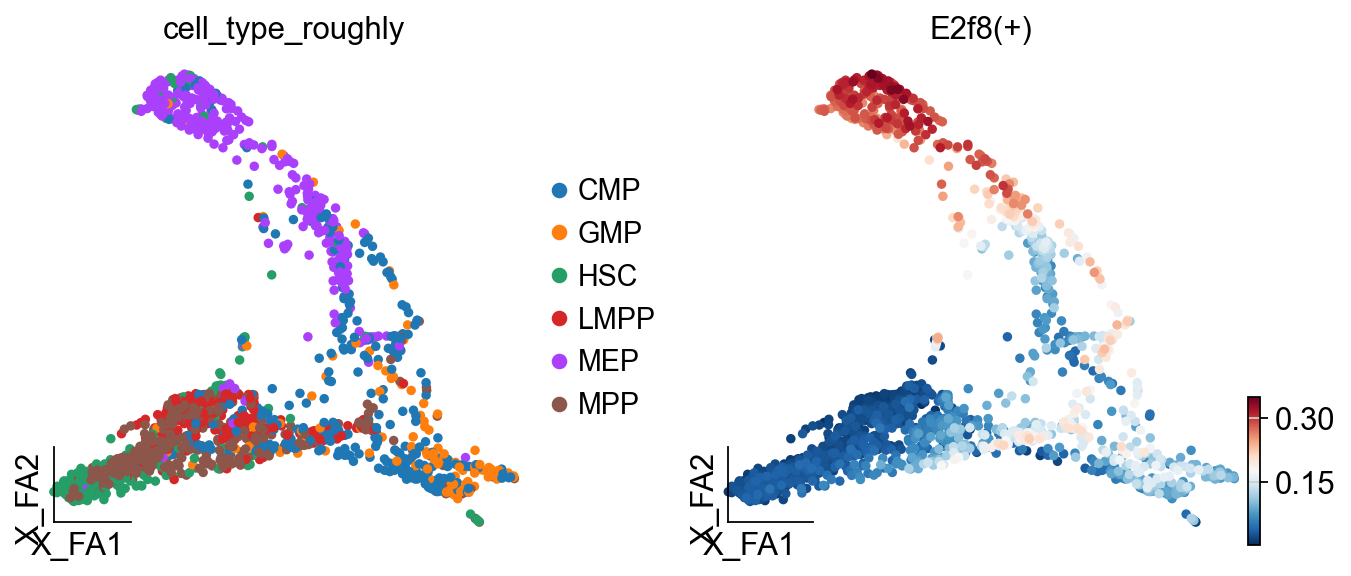

In [13]:
# Visualize regulon activity on the cell embedding
ov.pl.embedding(
    regulon_ad,
    basis='X_draw_graph_fa',              # Use the graph-based embedding
    color=['cell_type_roughly',           # Show cell types
           'E2f8(+)'],                    # Show E2f8 regulon activity
    ncols=2,                              # Two plots side by side
)

In [19]:
# Save the SCENIC object (contains all analysis results)
ov.utils.save(scenic_obj, 'results/scenic_obj.pkl')

# Save the regulon activity AnnData object
regulon_ad.write('results/scenic_regulon_ad.h5ad')

💾 Save Operation:
   Target path: results/scenic_obj.pkl
   Object type: SCENIC
   Using: pickle
   ✅ Successfully saved!
────────────────────────────────────────────────────────────


In [13]:
# Load the saved SCENIC results (for demonstration)
print("Loading previously saved SCENIC results...")

# Load the SCENIC object
scenic_obj = ov.utils.load('results/scenic_obj.pkl')

# Load the regulon activity AnnData object
regulon_ad = ov.read('results/scenic_regulon_ad.h5ad')

Loading previously saved SCENIC results...
📂 Load Operation:
   Source path: results/scenic_obj.pkl
   Using: pickle
   ✅ Successfully loaded!
   Loaded object type: SCENIC
────────────────────────────────────────────────────────────


## 5. Regulon Specificity Analysis

### Understanding Regulon Specificity Scores (RSS)

**RSS** measures how specific a regulon is to particular cell types:

- **Scale**: 0-1, where 1 indicates perfect cell-type specificity
- **Calculation**: Based on Jensen-Shannon divergence
- **Interpretation**: 
  - **High RSS** (>0.8): Regulon is highly specific to certain cell types
  - **Medium RSS** (0.5-0.8): Regulon shows moderate specificity
  - **Low RSS** (<0.5): Regulon is broadly active across cell types


In [20]:
# Import required modules for RSS analysis
from omicverse.external.pyscenic.rss import regulon_specificity_scores
from omicverse.external.pyscenic.plotting import plot_rss
from adjustText import adjust_text

### Calculate RSS Values

RSS calculation compares regulon activity distributions across cell types using Jensen-Shannon divergence.

In [21]:
# Calculate Regulon Specificity Scores (RSS)
print("Calculating RSS for all regulons across cell types...")

# Calculate RSS using the AUCell matrix and cell type annotations
rss = regulon_specificity_scores(
    scenic_obj.auc_mtx,                    # AUCell activity matrix
    scenic_obj.adata.obs['cell_type_roughly']  # Cell type annotations
)

print(f"RSS matrix shape: {rss.shape}")
print(f"Cell types: {list(rss.index)}")
print(f"Number of regulons: {len(rss.columns)}")
print(f"RSS value range: {rss.min().min():.3f} - {rss.max().max():.3f}")

# Display the RSS matrix
print("\nRSS matrix (first 5 regulons):")
rss.head()

Calculating RSS for all regulons across cell types...
RSS matrix shape: (6, 76)
Cell types: ['MPP', 'HSC', 'LMPP', 'GMP', 'CMP', 'MEP']
Number of regulons: 76
RSS value range: 0.167 - 0.610

RSS matrix (first 5 regulons):


,Batf3(+),Bhlhe40(+),Bsx(+),Ccdc160(+),E2f8(+),Egr1(+),Emx1(+),Ets1(+),Figla(+),Fos(+),...,Zfp184(+),Zfp202(+),Zfp263(+),Zfp28(+),Zfp366(+),Zfp426(+),Zfp467(+),Zfp563(+),Zfp709(+),Zik1(+)
MPP,0.199944,0.258951,0.189038,0.172145,0.265343,0.361861,0.297106,0.394170,0.244838,0.388107,...,0.177802,0.320348,0.195445,0.172142,0.167445,0.235907,0.405843,0.176695,0.294707,0.175499
HSC,0.195166,0.238137,0.196651,0.173135,0.248837,0.360502,0.275365,0.326099,0.236787,0.352855,...,0.181721,0.303036,0.206031,0.179339,0.167445,0.216771,0.373238,0.185735,0.270072,0.172124
LMPP,0.184871,0.213287,0.172320,0.167445,0.243831,0.307858,0.248572,0.381398,0.216452,0.343318,...,0.187108,0.281525,0.214272,0.167445,0.167445,0.213630,0.350174,0.213189,0.265295,0.178668
GMP,0.268309,0.242914,0.167445,0.167445,0.247438,0.226243,0.250688,0.242261,0.282441,0.229465,...,0.173822,0.286940,0.172080,0.167445,0.182066,0.190692,0.224789,0.173701,0.238102,0.167445
CMP,0.243563,0.232661,0.174204,0.167445,0.336468,0.328888,0.243225,0.327890,0.250185,0.330311,...,0.180738,0.341125,0.185506,0.167445,0.167445,0.235478,0.310437,0.186763,0.335201,0.167445


### RSS Visualization: Cell-Type-Specific Regulons

This comprehensive plot shows the **top 5 most specific regulons** for each cell type. The visualization helps identify:

- **Master regulators**: TFs with highest RSS for each cell type
- **Regulatory signatures**: Cell-type-specific TF programs
- **Developmental patterns**: TF specificity across the hematopoietic hierarchy

**Interpretation Guide**:
- **Y-axis**: RSS score (higher = more specific)
- **Labels**: Top 5 regulons for each cell type
- **Colors**: Different cell types
- **Patterns**: Notice which TFs are specific vs. broadly active

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


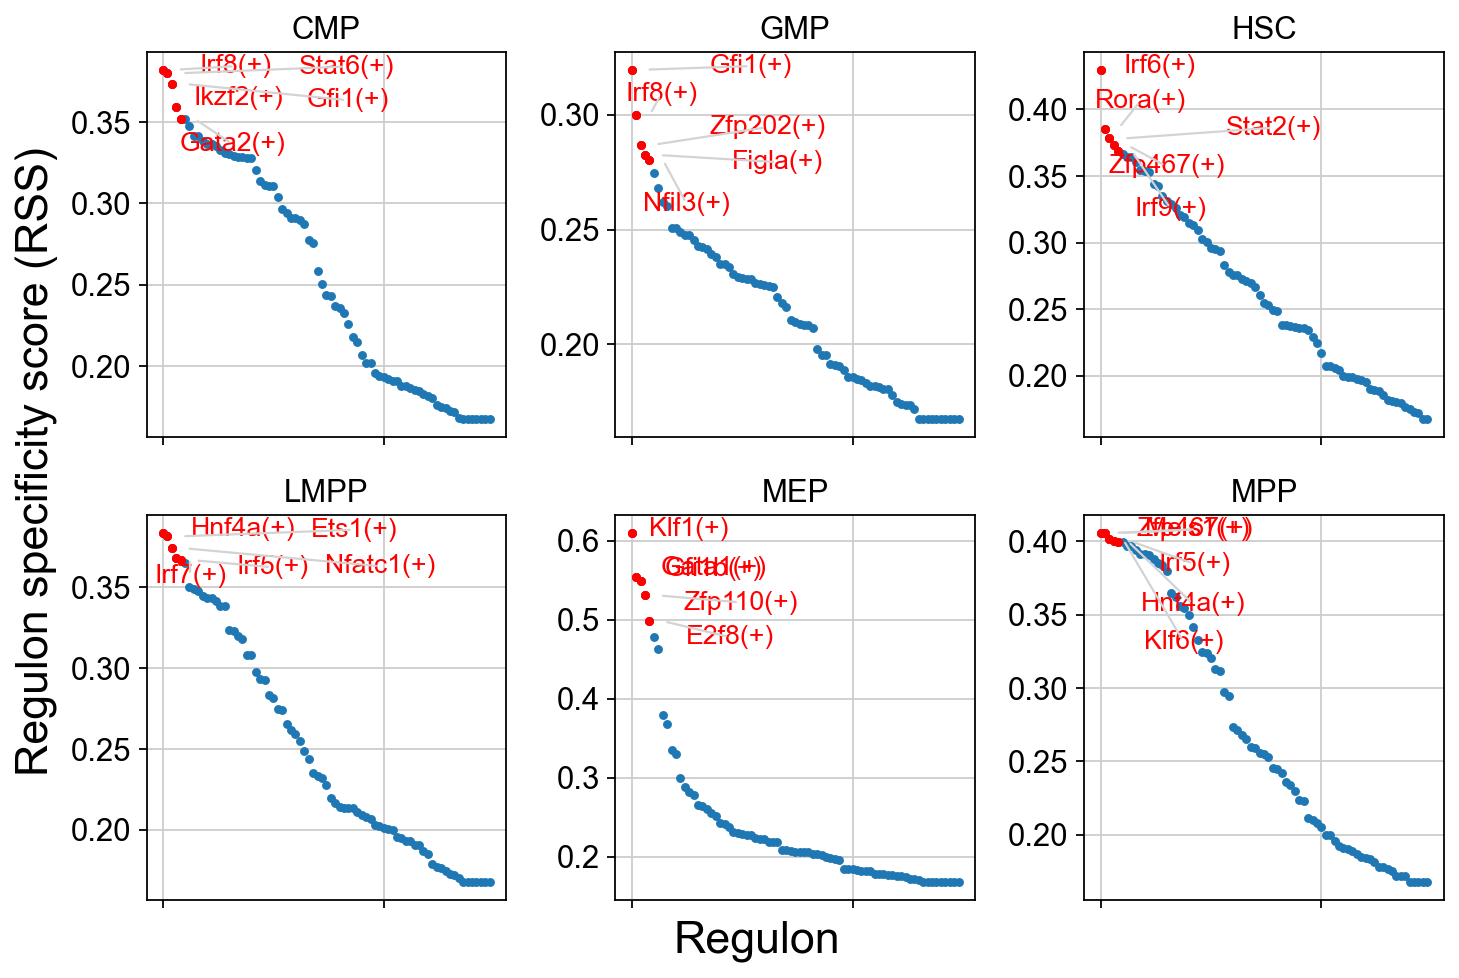

In [15]:
cats = sorted(list(set(adata.obs['cell_type_roughly'])))

fig = ov.plt.figure(figsize=(9, 6))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss.T[c]
    ax = fig.add_subplot(2,3,num)
    plot_rss(rss, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', 
                va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
ov.plt.tight_layout()

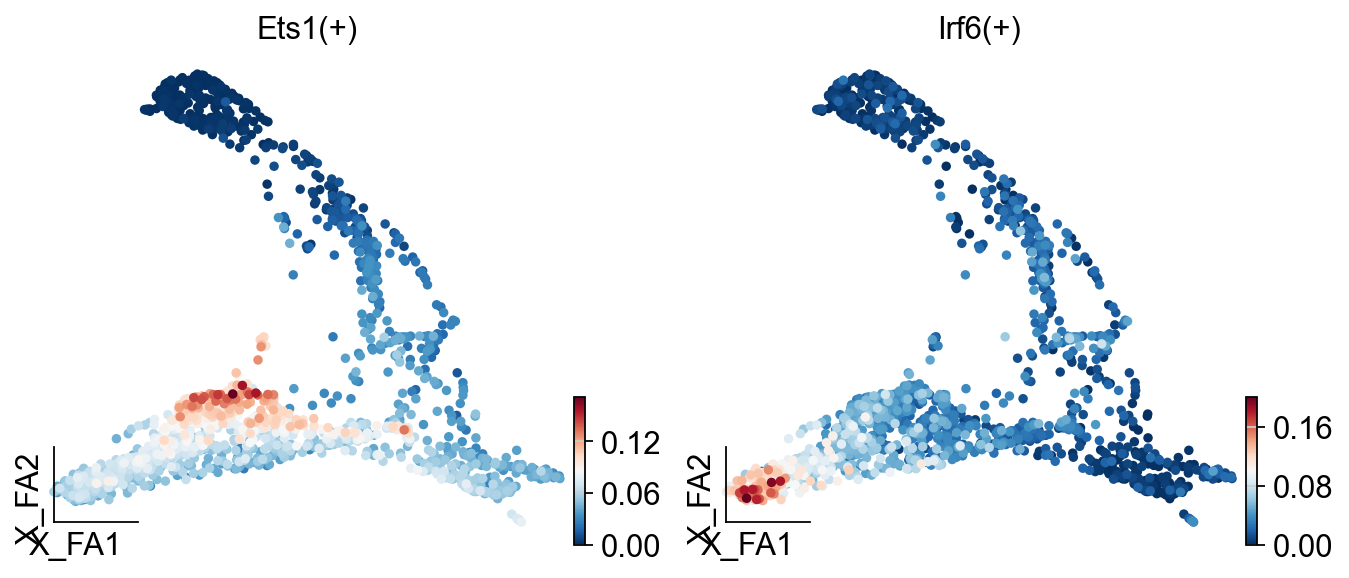

In [17]:
ov.pl.embedding(
    regulon_ad,
    basis='X_draw_graph_fa',
    color=['Ets1(+)',
            'Irf6(+)']
)

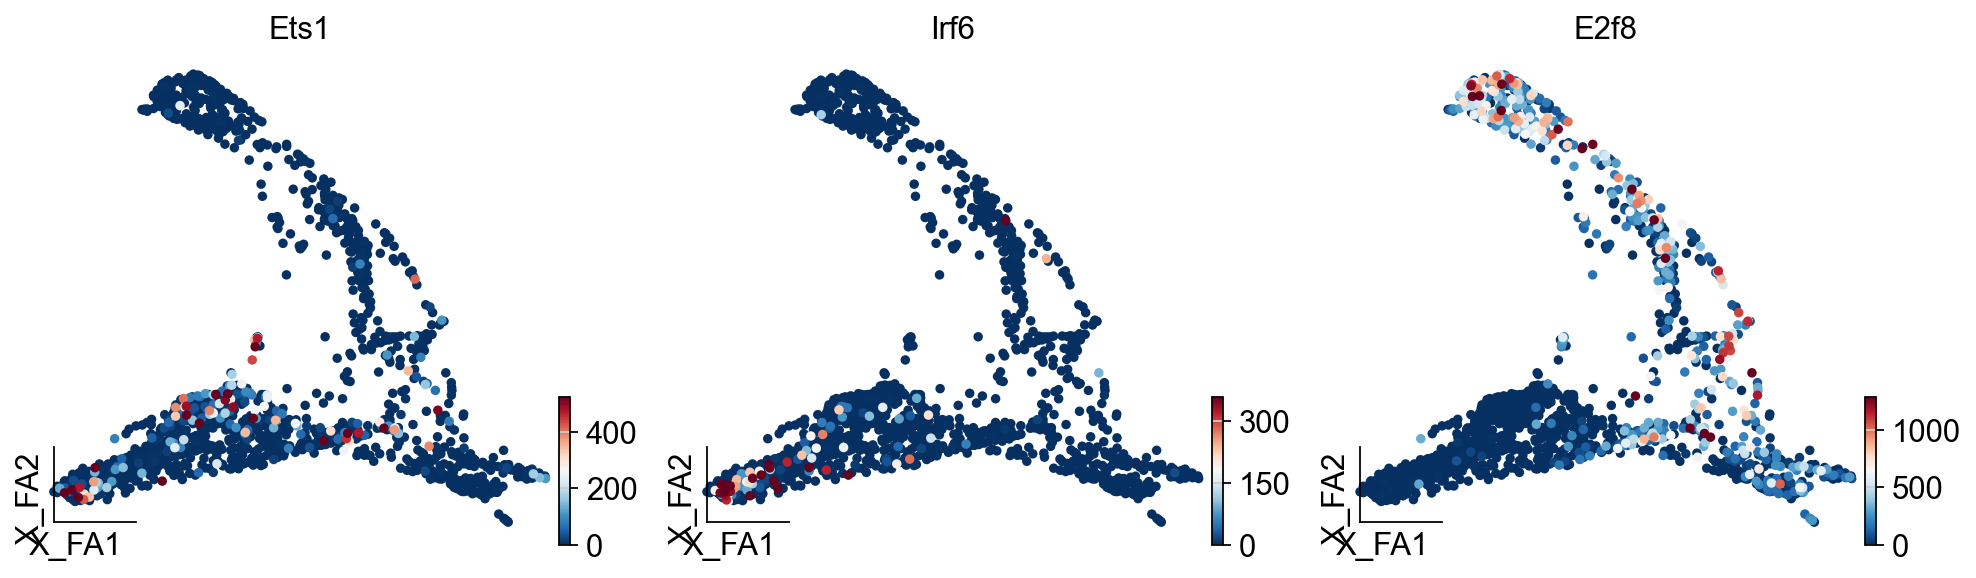

In [18]:
ov.pl.embedding(
    adata,
    basis='X_draw_graph_fa',
    color=['Ets1','Irf6','E2f8'],
    vmax='p99.2'
)

In [19]:
regulon_ad

AnnData object with n_obs × n_vars = 1645 × 76
    obs: 'E_pseudotime', 'GM_pseudotime', 'L_pseudotime', 'label_info', 'n_genes', 'leiden', 'cell_type_roughly', 'cell_type_finely'
    uns: 'cell_type_roughly_colors'
    obsm: 'X_draw_graph_fa', 'X_pca'

Storing dendrogram info using `.uns['dendrogram_cell_type_roughly']`
ranking genes
    finished: added to `.uns['cell_type_roughly_ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


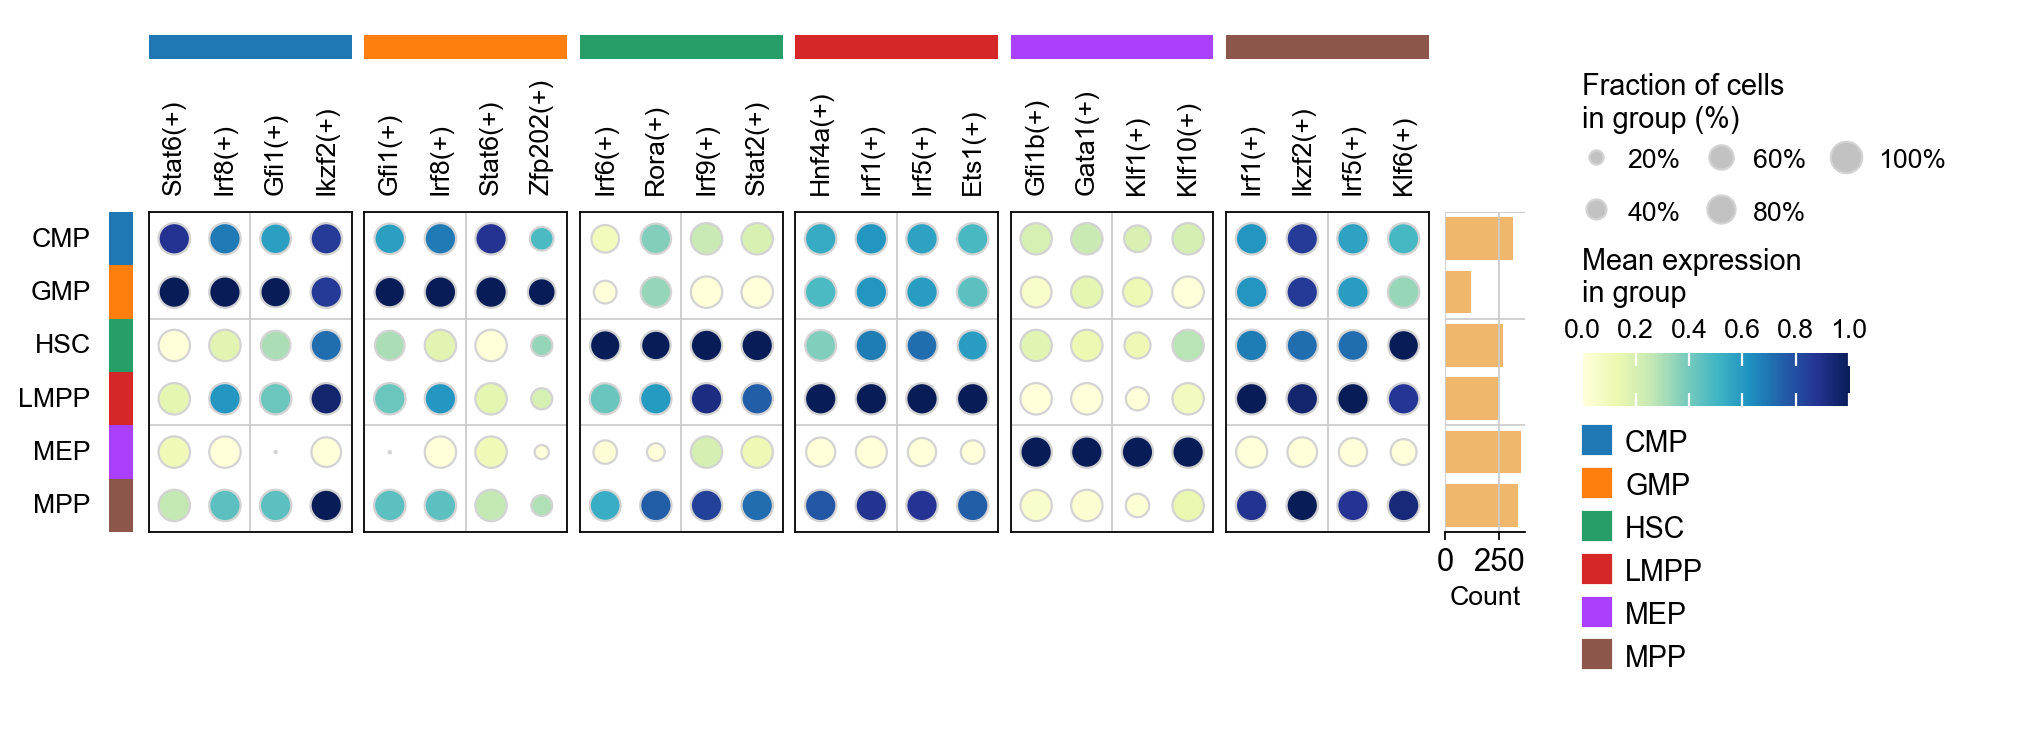

In [20]:
sc.tl.dendrogram(regulon_ad,'cell_type_roughly',use_rep='X_pca')
sc.tl.rank_genes_groups(regulon_ad, 'cell_type_roughly', use_rep='X_pca',
                        method='t-test',use_raw=False,key_added='cell_type_roughly_ttest')
ov.pl.rank_genes_groups_dotplot(regulon_ad,groupby='cell_type_roughly',
                                cmap='YlGnBu',key='cell_type_roughly_ttest',
                                standard_scale='var',n_genes=4,dendrogram=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
**finished identifying marker genes by COSG**


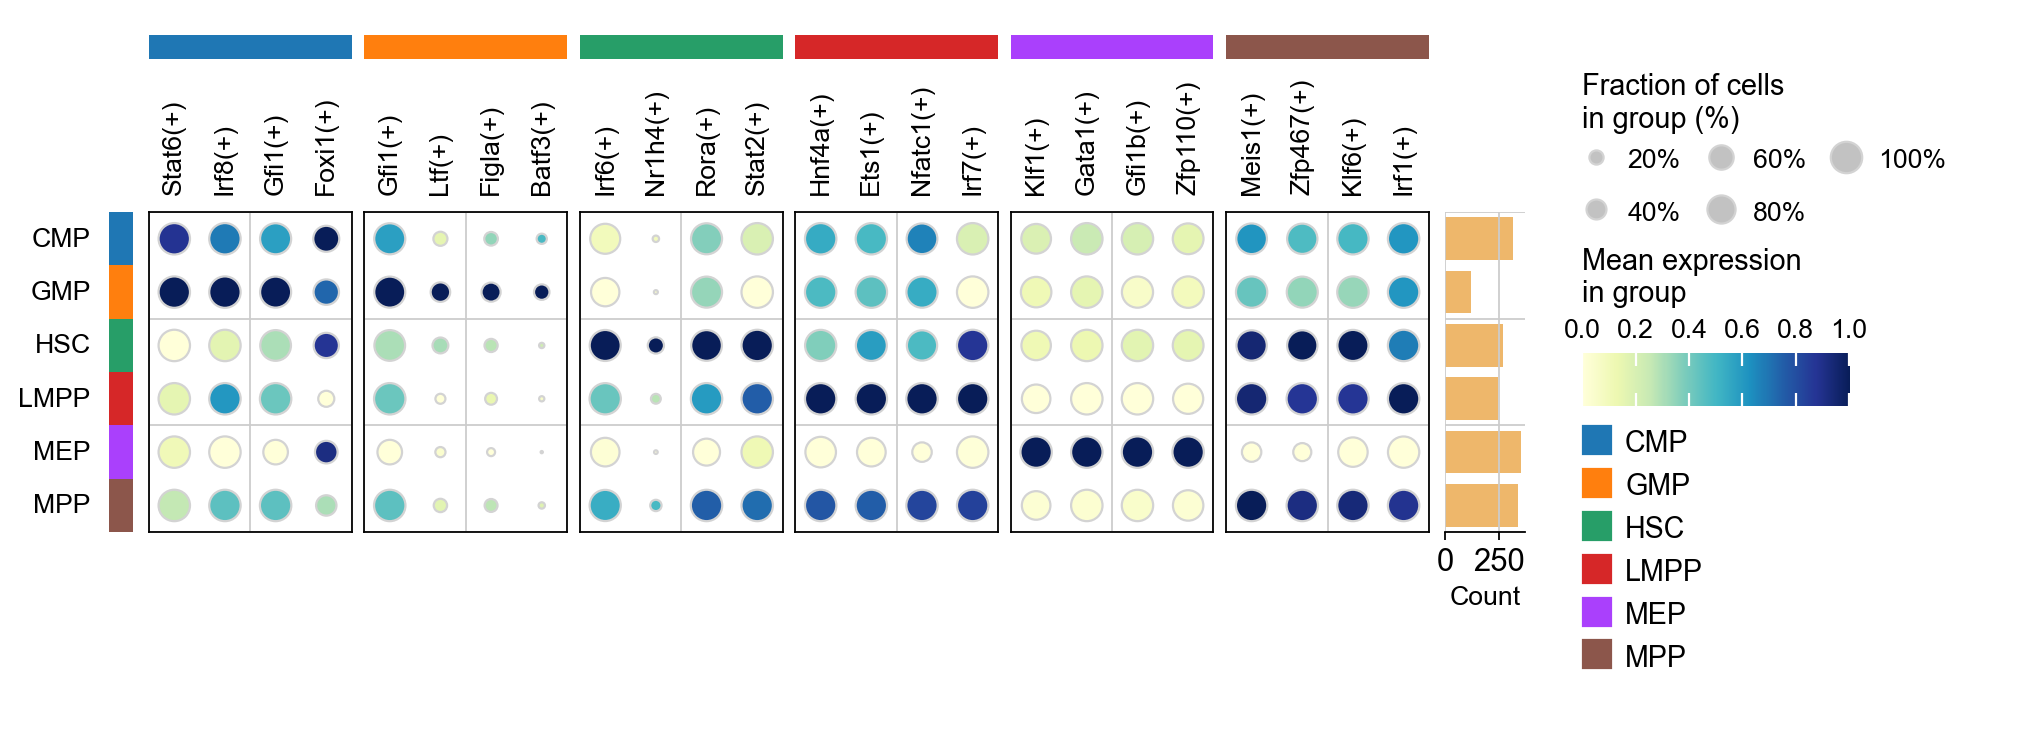

In [21]:
sc.tl.rank_genes_groups(regulon_ad, groupby='cell_type_roughly', 
                        method='t-test',use_rep='scaled|original|X_pca',)
ov.single.cosg(regulon_ad, key_added='cell_type_roughly_cosg', groupby='cell_type_roughly')
ov.pl.rank_genes_groups_dotplot(regulon_ad,groupby='cell_type_roughly',
                                cmap='YlGnBu',key='cell_type_roughly_cosg',
                                standard_scale='var',n_genes=4,dendrogram=False)

### Generate a binary regulon activity matrix

In [24]:
from omicverse.external.pyscenic.binarization import binarize
binary_mtx, auc_thresholds = binarize(
    scenic_obj.auc_mtx, num_workers=12 
)
binary_mtx.head()

Regulon,Batf3(+),Bhlhe40(+),Bsx(+),Ccdc160(+),E2f8(+),Egr1(+),Emx1(+),Ets1(+),Figla(+),Fos(+),...,Zfp184(+),Zfp202(+),Zfp263(+),Zfp28(+),Zfp366(+),Zfp426(+),Zfp467(+),Zfp563(+),Zfp709(+),Zik1(+)
Cell,,,,,,,,,,,,,,,,,,,,,
HSPC_025,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
LT-HSC_001,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0
HSPC_008,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,1,0,0,0
HSPC_020,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
HSPC_026,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


### Show the AUC distributions for selected regulons

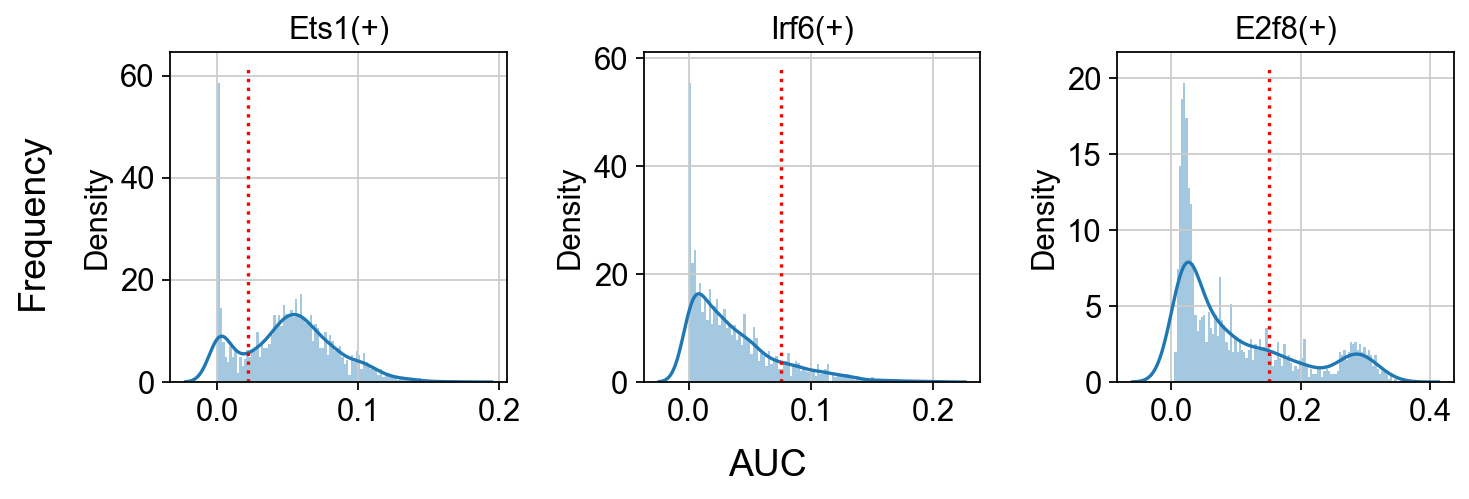

In [25]:
# select regulons:
import seaborn as sns
r = [ 'Ets1(+)','Irf6(+)','E2f8(+)' ]

fig, axs = ov.plt.subplots(1, 3, figsize=(9, 3), dpi=80, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(scenic_obj.auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()

## GRN exploration and visualization 

In [27]:
tf = 'Irf6'
tf_mods = [ x for x in scenic_obj.modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )

tf_regulons = [ x for x in scenic_obj.regulons if x.transcription_factor==tf ]
for i,mod in enumerate( tf_regulons ):
    print( f'{tf} regulon: {len(mod.genes)} genes' )

Irf6 module 0: 425 genes
Irf6 module 1: 175 genes
Irf6 module 2: 51 genes
Irf6 module 3: 46 genes
Irf6 regulon: 70 genes


In [28]:
tf_list=[i.replace('(+)','') for i in regulon_ad.var_names.tolist()]
gene_list=[]

# TF-Target dict
tf_gene_dict={}
for tf in tf_list:
    tf_regulons = [ x for x in scenic_obj.regulons if x.transcription_factor==tf ]
    for i,mod in enumerate( tf_regulons ):
        gene_list+=mod.genes
        tf_gene_dict[tf]=list(mod.genes)

gene_list+=tf_list
gene_list=list(set(gene_list))

In [29]:
adata_T=adata[:,gene_list].copy().T
sc.tl.pca(adata_T)
sc.pp.neighbors(adata_T,use_rep='X_pca')
sc.tl.umap(adata_T)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)


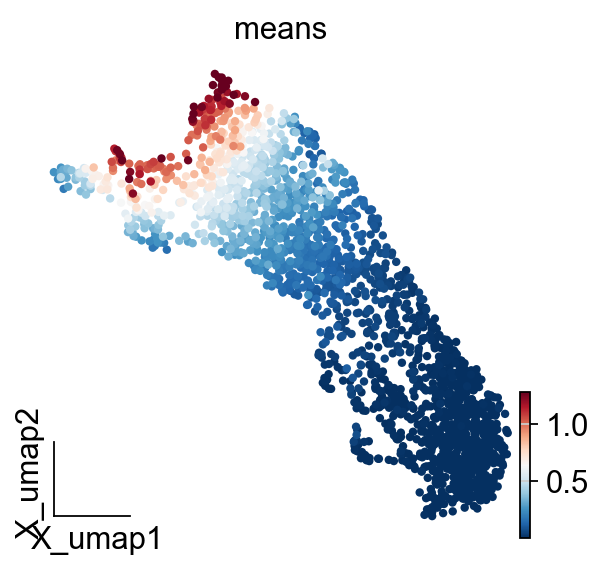

In [30]:
ov.pl.embedding(
    adata_T,
    basis='X_umap',
    color=['means'],
    vmax='p99.2'
)

In [32]:
embedding_df=ov.pd.DataFrame(
    adata_T.obsm['X_pca'],
    index=adata_T.obs.index
)
embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Otub2,-92.633224,56.502110,-31.578060,5.653144,-24.708723,1.281281,1.947693,11.790207,-6.796351,-10.819179,...,10.759730,-0.643292,-4.945858,8.733842,-2.410317,0.207230,-6.987343,6.510520,-1.010490,-12.032227
Msmo1,145.103867,-48.607029,-70.588257,-5.135292,-72.118103,-5.485968,-50.650715,-1.268654,-49.936626,12.455015,...,37.755577,25.194468,-3.562634,6.602799,-46.525181,-67.506973,-19.098345,47.795597,47.715561,-35.440521
Tspan3,570.911133,-233.319778,-69.265144,-106.029449,-124.118683,49.517864,-107.317894,13.309699,-13.920894,15.276391,...,44.824017,9.967918,-48.454159,-4.164706,25.847649,-16.883493,-11.819862,21.171194,4.481363,50.354259
Hhatl,-173.784363,14.085079,5.902175,4.108379,2.453918,1.959094,-5.654883,-3.918759,3.879693,-1.046933,...,-0.358620,0.009381,-0.296779,-0.544328,-0.125946,-0.281507,0.407999,0.272420,-0.086473,0.013038
Nap1l2,-172.701645,13.268181,5.349567,3.737204,2.004823,1.811748,-6.148868,-4.865162,3.179567,0.030973,...,-0.444562,-0.498110,-0.460469,-0.630476,0.059810,-0.315913,-0.126209,-0.215298,1.166200,1.281393


In [33]:
# 构建网络
G, pos, correlation_matrix = ov.single.build_correlation_network_umap_layout(
    embedding_df, 
    correlation_threshold=0.95,  
    umap_neighbors=15
)

Network built successfully:
  Node number: 2095
  Edge number: 421200
  Correlation threshold: 0.95


In [34]:
G, tf_genes = ov.single.add_tf_regulation(G, tf_gene_dict)

Add regulation relationship:
  TF gene number: 76
  Regulation edge number: 5564


In [35]:
temporal_df=adata_T.obs.copy()
temporal_df['peak_temporal_center']=temporal_df['means']

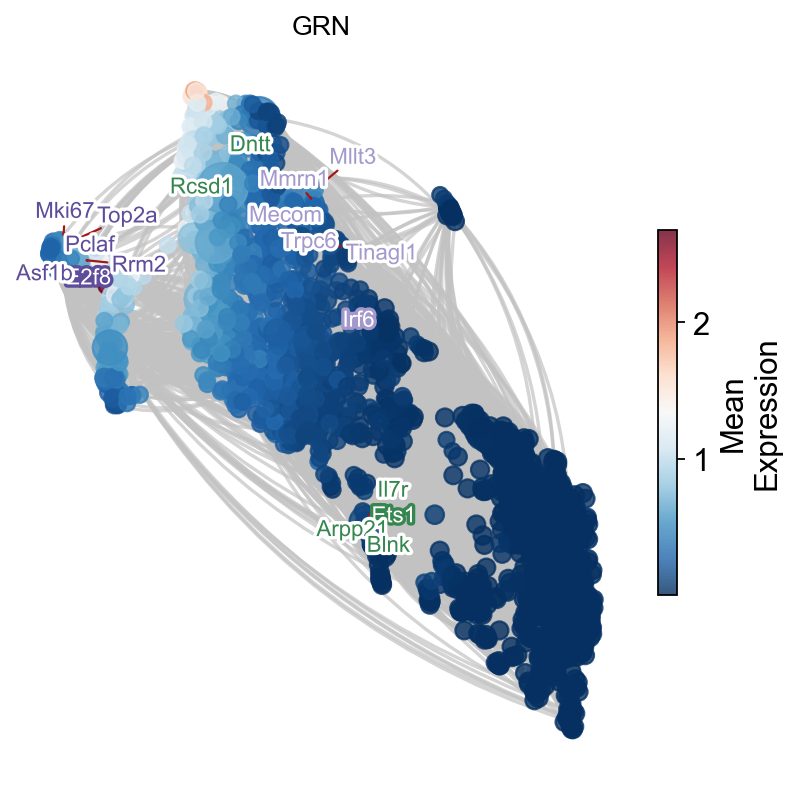

In [37]:
ax=ov.single.plot_grn(
    G,pos, ['Ets1','Irf6','E2f8'],
    temporal_df,tf_gene_dict,
    figsize=(6,6),top_tf_target_num=5,title='GRN'
)

### What is SCENIC?

SCENIC is designed to simultaneously:
- **Infer transcription factor (TF) regulatory networks** from single-cell expression data
- **Identify cell states** based on regulatory activity profiles
- **Discover cell-type-specific regulons** (TF + direct target genes)
- **Quantify TF activity** in individual cells

### The SCENIC Workflow

The SCENIC pipeline consists of **three main steps**:

#### 1. **Gene Regulatory Network (GRN) Inference**
- **Traditional Method**: Uses GRNBoost2 or GENIE3 to identify potential TF-target relationships
- **New Method**: RegDiffusion - a deep learning approach that's **10x faster** and more accurate
- **Input**: Single-cell expression matrix
- **Output**: Adjacency matrix with TF-target importance scores

#### 2. **Regulon Inference (Pruning)**
- **Method**: Uses cisTarget to perform TF-motif enrichment analysis
- **Purpose**: Refines co-expression modules to retain only **direct targets**
- **Process**: Searches for TF-binding motifs in target gene regulatory regions
- **Output**: **Regulons** = TF + genes with motif support

#### 3. **Cell-level Activity Scoring (AUCell)**
- **Method**: Calculates Area Under the Curve (AUC) for gene rankings
- **Purpose**: Quantifies regulon activity in individual cells
- **Output**: Activity matrix (cells × regulons)